# Analysis of Model Selection measures

In [123]:
import glob
import os
import pandas as pd
import json
import numpy as np
from skimage.segmentation import disk_level_set

print(os.getcwd())
paths = glob.glob('../outputs/*/*/*dict_output.json')

/Users/heather/GitHub/aldi0107/dev_stuff


In [127]:
import os
import json
from collections import defaultdict


def get_measure_name(output_filename):
    return os.path.basename(output_filename).split('_dict_output')[0]



path_dict = defaultdict(list)

for p in paths:
    base_path, result_file = os.path.split(p)
    path_dict[base_path].append(result_file)

result_fields = {'BoS': ['BoS'],
                 'MINE': ['AP50', 'loss_box_giou', 'loss_score_logits', 'entropy', 'info_max_reg'],
                 'DAS': ['DAS', 'PDR_normalized', 'FIS_normalized', 'FIS', 'PDR'],}
rows = []

for base_path, result_files in path_dict.items():
    split_path = base_path.split('/')
    domain = split_path[-2]
    method = split_path[-1]
    datas = {}
    for result_file in result_files:
        with open(os.path.join(base_path, result_file), 'r') as file:
            data = json.load(file)
        measure = get_measure_name(result_file)
        if measure not in ['DAS']:
            data = {os.path.basename(k): results for k, results in data.items()}
        datas[measure] = data
    models = datas['MINE'].keys()
    for m in models:
        iterations = int(m[-11:-4])
        row = [domain,method, m, iterations]
        for measure, fields in result_fields.items():
            model_measure_data = datas[measure].get(m, None)
            if model_measure_data is not None:
                datasets = [k for k in datas[measure].get(m, None).keys() if '_val' in k or 'test' in k]
                if len(datasets)!= 1:
                    print(f"Can't get val dataset: {row} {measure} {m} {datasets}")
                results = datas[measure][m][datasets[0]]
            for f in fields:
                if model_measure_data is not None:
                    if type(results[f]) is list:
                        result = results[f][0]
                    elif type(results[f]) is dict:
                        result = results[f]['1'][0] # FIS storage
                    else:
                        result = results[f]
                    row.append(result)
                else:
                    row.append(np.NaN)
        rows.append(row)
headings = ['domain', 'method', 'model', 'iters']
for measure, fields in result_fields.items():
    for f in fields:
        headings.append(f"{measure}_{f}")

df = pd.DataFrame(data=rows, columns=headings)

df['MINE_sum'] = df['MINE_entropy'] + df['MINE_info_max_reg']
df['MINE_diff'] = - df['MINE_entropy'] + df['MINE_info_max_reg']
df['MINE_comb'] =df['MINE_loss_box_giou'] - df['MINE_loss_score_logits']


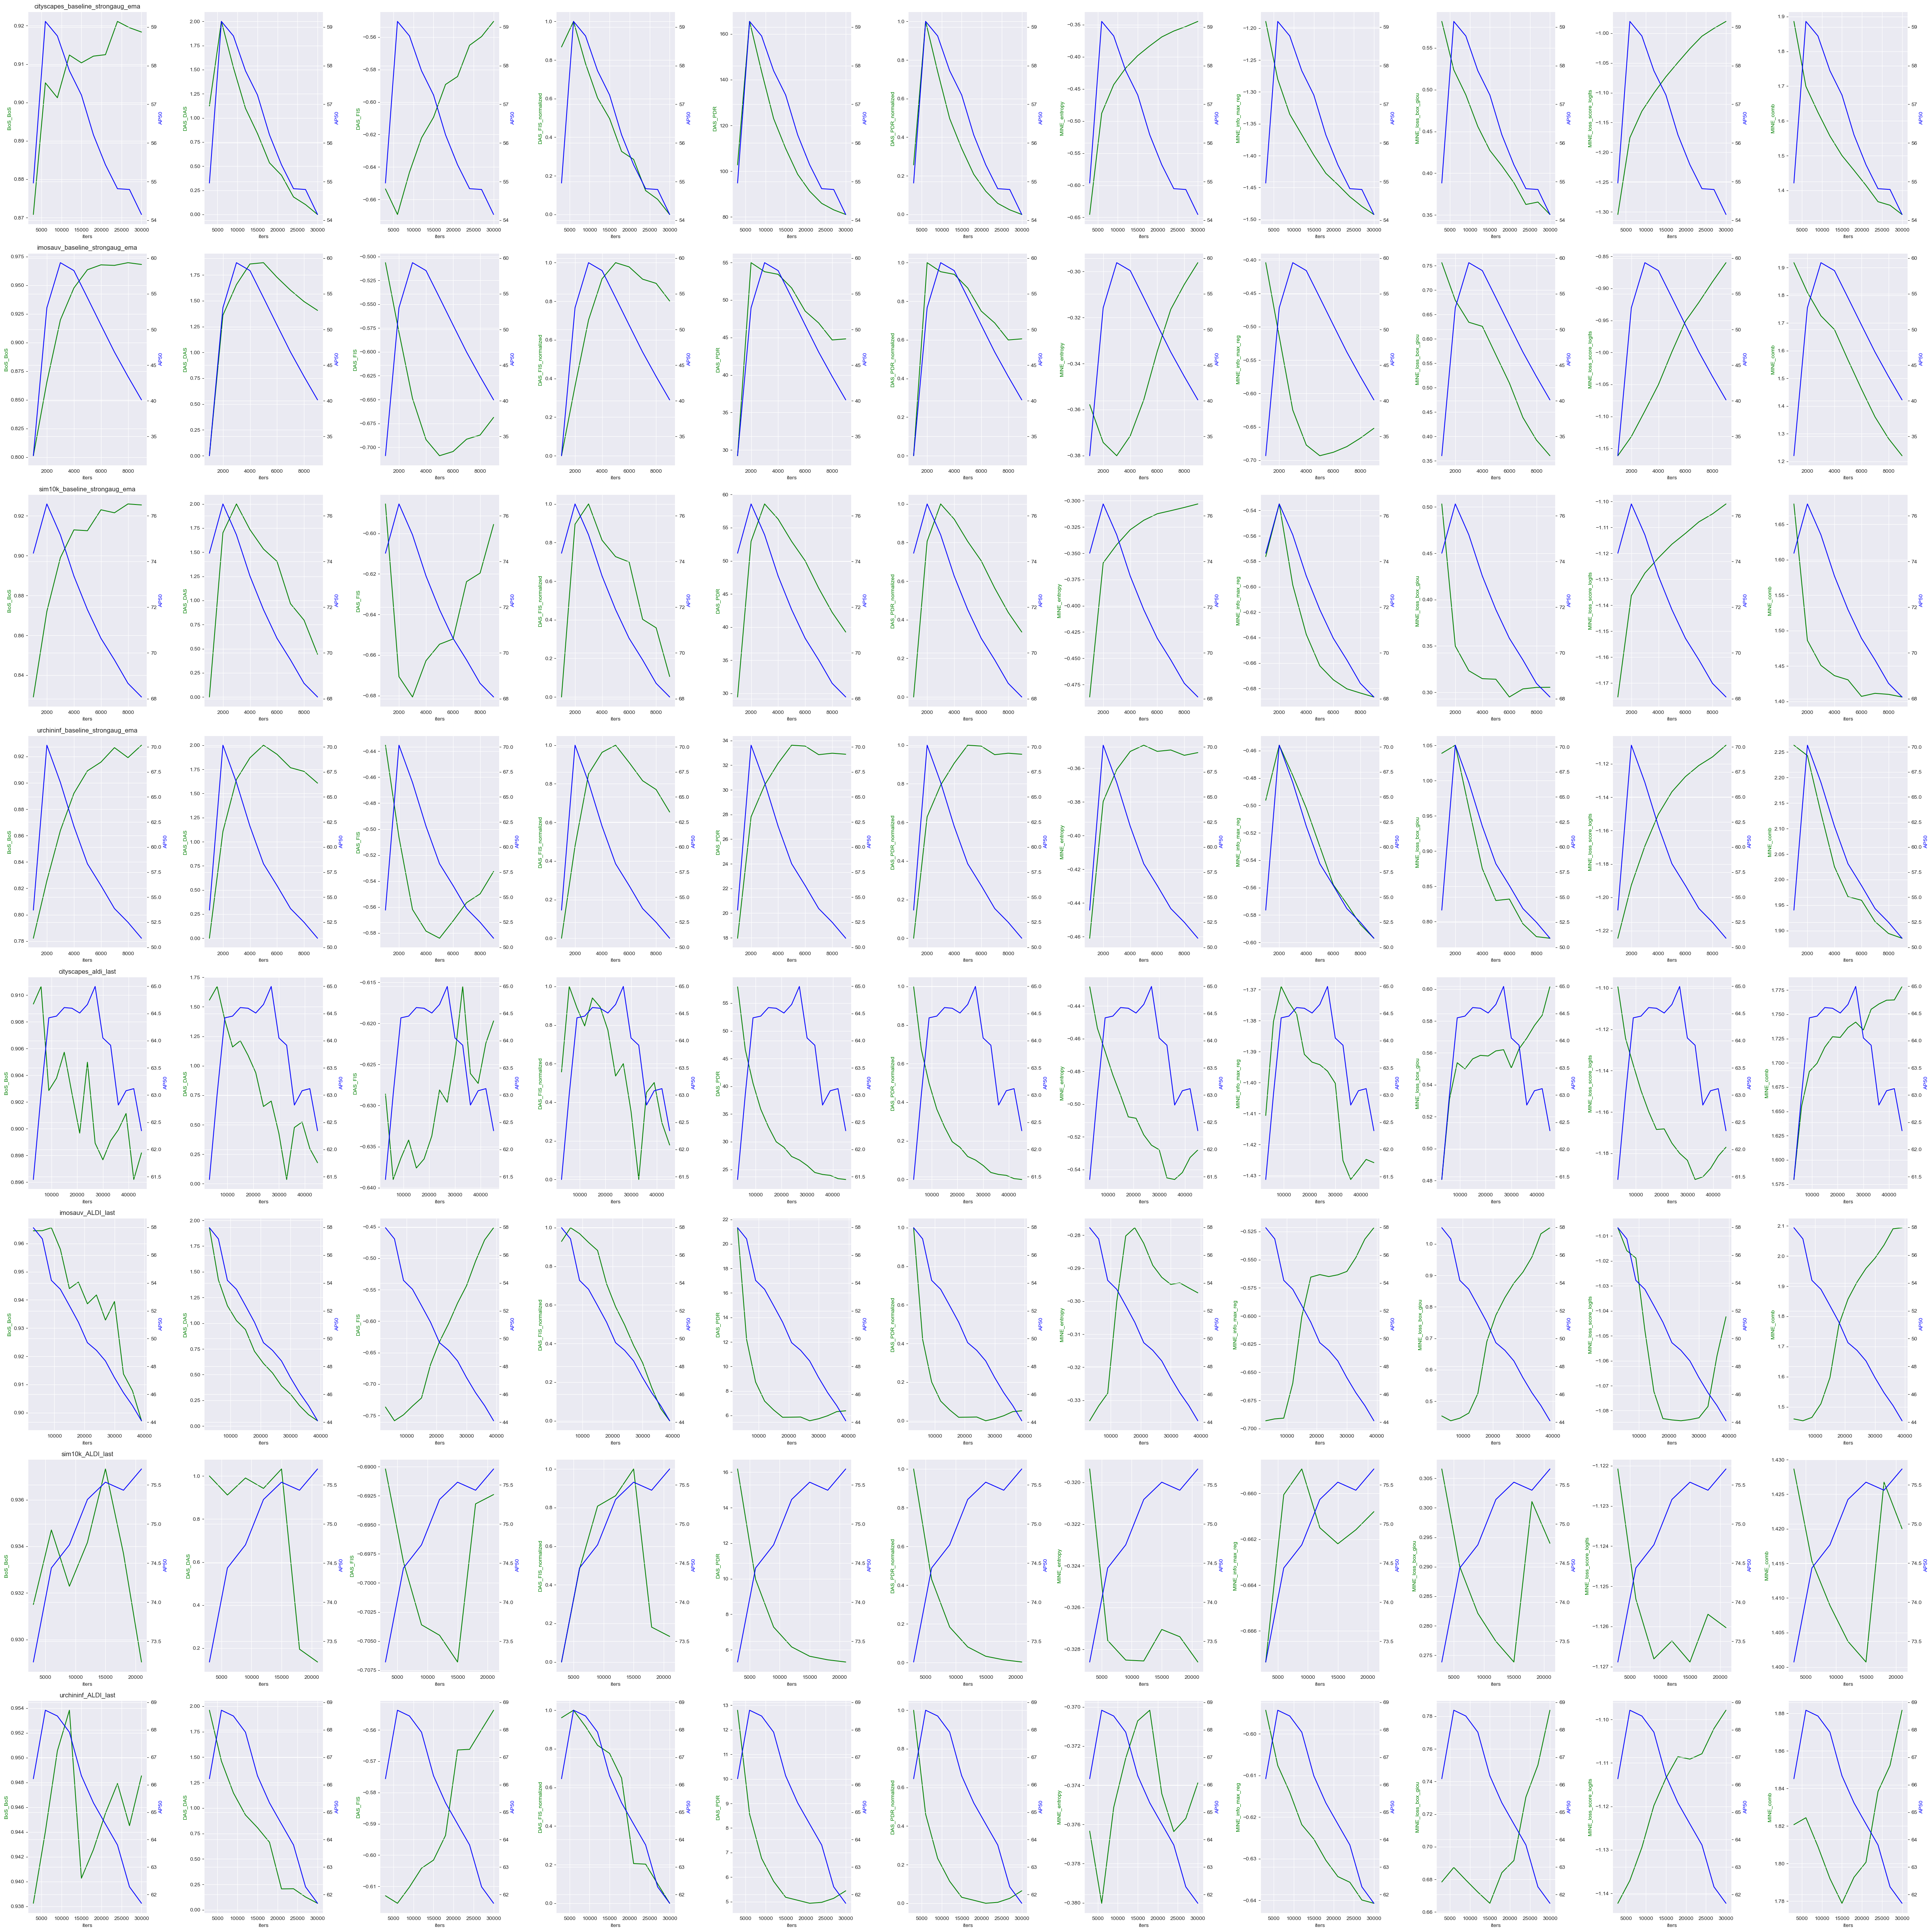

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

vals = sorted([h for h in headings[4:] if 'AP50' not in h]) + ['MINE_comb'] #+ ['MINE_sum', 'MINE_diff']

import matplotlib.pyplot as plt
import pandas as pd

methods = sorted(list(set(df['method'])))
methods = [m for m in methods if 'strongaug' in m] + [m for m in methods if 'aldi' in m.lower()]
fig, axes = plt.subplots(len(methods), len(vals), figsize=(50, 50))

# Create subplots
for j, method in enumerate(methods):
    sub_df = df[df['method']==method]#[df['iters'] > 2999]

    # Plot each y variable against the common x variable
    for i, val in enumerate(vals):
        axes[j, i].plot(sub_df['iters'], sub_df[val], color='green')
        axes[j, i].set_ylabel(val, color='green')
        axes[j, i].set_xlabel('iters')
        axes[j, i].grid(True)


        # Create a second y-axis sharing the same x-axis
        ax2 = axes[j, i].twinx()
        ax2.plot(sub_df['iters'], sub_df['MINE_AP50'], 'b-')
        ax2.set_ylabel('AP50', color='b')
        if i == 0:
            axes[j,i].set_title(f"{method}")
    # Set common x label
    #axes[-1].set_xlabel('iters')

    # Show plot
plt.tight_layout()
plt.show()

